In [1]:
import json
import re
from typing import Dict, List, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
def most_recent_file():
    import os
    import glob
    list_of_files = glob.glob('logs/*') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    return latest_file


def load_log_file(file_path: str):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Split the file into three sections
    sections = re.split(r'\n\n+(?:Sandbox logs:|Activities log:|Trade History:)\n', content)
    
    # Parse each section
    assert len(sections) == 3, "Expected 3 sections in the log file"


    sandbox_logs = parse_sandbox_logs(sections[0])
    activities_log = parse_activities_log(sections[1])
    trade_history = parse_trade_history(sections[2])
    
    return sandbox_logs, activities_log, trade_history


def parse_sandbox_logs(logs_text: str):
    """Parse the sandbox logs section into a list of log entries."""
    # First clean up the text to make it valid JSON array
    logs_text = logs_text.replace('Sandbox logs:\n','').strip()
    
    # Replace multiple newlines between JSON objects with a single comma
    logs_text = re.sub(r'}\s*\n\s*{', '},{', logs_text)
    
    # Wrap in array brackets if not already present
    if not logs_text.startswith('['):
        logs_text = '[' + logs_text
    if not logs_text.endswith(']'):
        logs_text = logs_text + ']'
    
    try:
        log_entries = json.loads(logs_text)
        # Parse lambdaLog for each entry - but don't try to json.loads() it
        for entry in log_entries:
            if 'lambdaLog' in entry and entry['lambdaLog']:
                entry['parsed_lambda'] = entry['lambdaLog']
                
        return pd.DataFrame(log_entries)
    except json.JSONDecodeError as e:
        print(f"JSON Decode Error: {e}")
        return pd.DataFrame(columns=['sandboxLog', 'lambdaLog', 'timestamp'])


def parse_activities_log(activities_text: str) -> pd.DataFrame:
    """Parse the activities log section into a pandas DataFrame."""
    # Split the text into lines
    lines = activities_text.strip().split('\n')
    
    # Extract the header
    header = lines[0].split(';')
    
    # Parse the data rows
    data = []
    for line in lines[1:]:
        if line.strip():  # Skip empty lines
            values = line.split(';')
            data.append(values)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=header)
    
    # Convert numeric columns
    numeric_columns = [
        'timestamp', 
        'bid_price_1', 'bid_volume_1', 
        'bid_price_2', 'bid_volume_2',
        'bid_price_3', 'bid_volume_3',
        'ask_price_1', 'ask_volume_1',
        'ask_price_2', 'ask_volume_2',
        'ask_price_3', 'ask_volume_3',
        'mid_price', 'profit_and_loss'
    ]
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df


def parse_trade_history(trade_text: str) -> pd.DataFrame:
    """Parse the trade history section into a pandas DataFrame."""
    
    trades = json.loads(trade_text)
    df = pd.DataFrame(trades)
    return df


    

In [3]:
file_path = most_recent_file()
sandbox_logs, activities_log, trade_history = load_log_file(file_path)

logs\c5a07023-f0ed-4ea0-85f9-3c24bdd425db.log


In [4]:
sandbox_logs

,sandboxLog,lambdaLog,timestamp,parsed_lambda
0,,traderData: \nObservations: (plainValueObserva...,0,traderData: \nObservations: (plainValueObserva...
1,,traderData: SAMPLE\nObservations: (plainValueO...,100,traderData: SAMPLE\nObservations: (plainValueO...
2,,traderData: SAMPLE\nObservations: (plainValueO...,200,traderData: SAMPLE\nObservations: (plainValueO...
3,,traderData: SAMPLE\nObservations: (plainValueO...,300,traderData: SAMPLE\nObservations: (plainValueO...
4,\nOrders for product SQUID_INK exceeded limit ...,traderData: SAMPLE\nObservations: (plainValueO...,400,traderData: SAMPLE\nObservations: (plainValueO...
...,...,...,...,...
995,\nOrders for product RAINFOREST_RESIN exceeded...,traderData: SAMPLE\nObservations: (plainValueO...,99500,traderData: SAMPLE\nObservations: (plainValueO...
996,\nOrders for product RAINFOREST_RESIN exceeded...,traderData: SAMPLE\nObservations: (plainValueO...,99600,traderData: SAMPLE\nObservations: (plainValueO...
997,\nOrders for product RAINFOREST_RESIN exceeded...,traderData: SAMPLE\nObservations: (plainValueO...,99700,traderData: SAMPLE\nObservations: (plainValueO...
998,\nOrders for product RAINFOREST_RESIN exceeded...,traderData: SAMPLE\nObservations: (plainValueO...,99800,traderData: SAMPLE\nObservations: (plainValueO...


In [5]:
activities_log

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,SQUID_INK,1834,23,NaN,NaN,NaN,NaN,1838,23,NaN,NaN,NaN,NaN,1836.0,0.000000
1,1,0,RAINFOREST_RESIN,9998,9,9995.0,23.0,NaN,NaN,10005,23,NaN,NaN,NaN,NaN,10001.5,0.000000
2,1,0,KELP,2032,23,NaN,NaN,NaN,NaN,2035,23,NaN,NaN,NaN,NaN,2033.5,0.000000
3,1,100,KELP,2034,1,2033.0,2.0,2032.0,22.0,2035,22,NaN,NaN,NaN,NaN,2034.5,-31.910156
4,1,100,SQUID_INK,1837,1,1836.0,2.0,1835.0,22.0,1839,22,NaN,NaN,NaN,NaN,1838.0,-68.964844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,99800,SQUID_INK,1814,26,NaN,NaN,NaN,NaN,1817,26,NaN,NaN,NaN,NaN,1815.5,914.796875
2996,1,99800,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10002,5,10004.0,1.0,10005.0,25.0,9999.0,-186.000000
2997,1,99900,SQUID_INK,1816,27,NaN,NaN,NaN,NaN,1819,28,NaN,NaN,NaN,NaN,1817.5,826.062500
2998,1,99900,RAINFOREST_RESIN,9998,6,9996.0,1.0,9995.0,27.0,10004,1,10005.0,27.0,NaN,NaN,10001.0,-186.000000


In [6]:
trade_history

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,,SUBMISSION,KELP,SEASHELLS,2032,23
1,0,,SUBMISSION,RAINFOREST_RESIN,SEASHELLS,9998,9
2,0,,SUBMISSION,SQUID_INK,SEASHELLS,1834,23
3,100,,SUBMISSION,KELP,SEASHELLS,2034,1
4,100,,SUBMISSION,RAINFOREST_RESIN,SEASHELLS,10002,1
...,...,...,...,...,...,...,...
856,99700,,,KELP,SEASHELLS,2034,2
857,99700,,,RAINFOREST_RESIN,SEASHELLS,9995,2
858,99700,,,SQUID_INK,SEASHELLS,1813,2
859,99900,,,KELP,SEASHELLS,2035,1


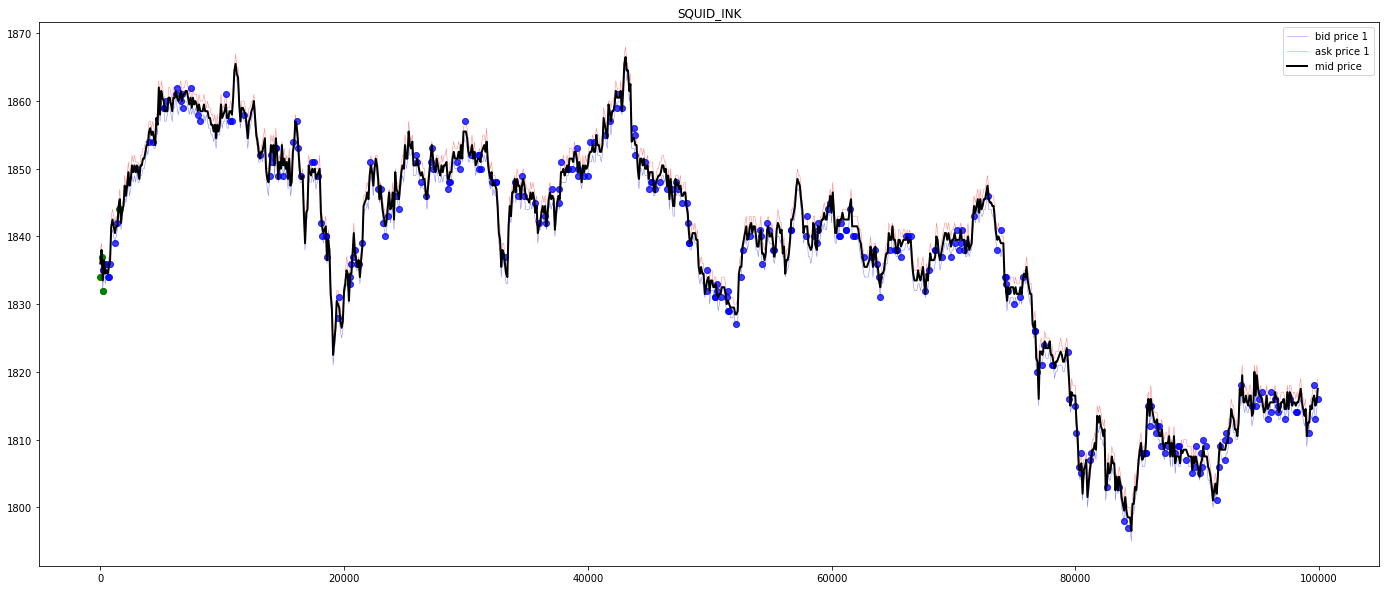

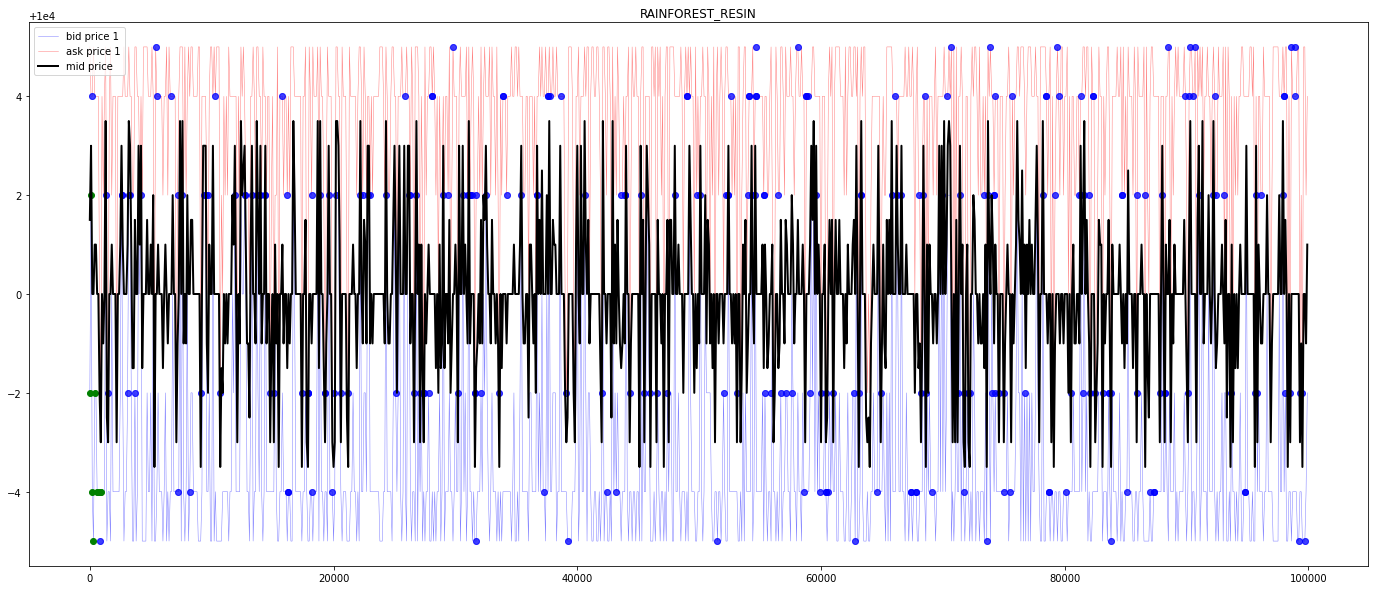

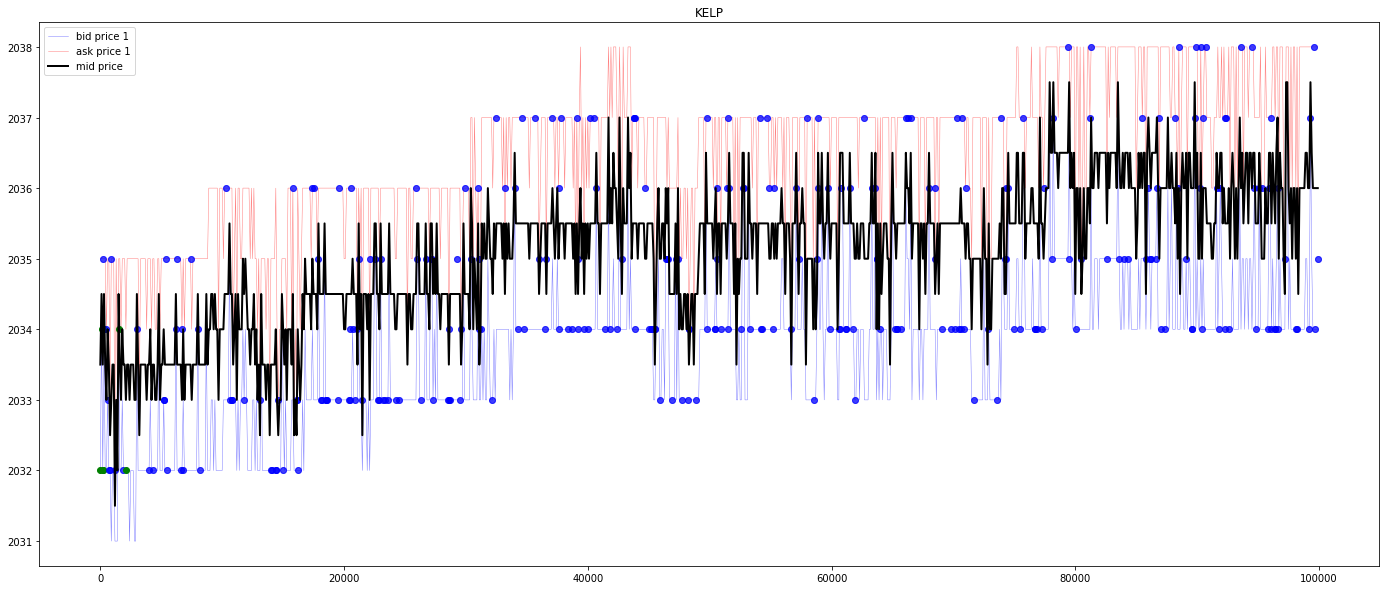

In [7]:
for product in activities_log['product'].unique():
    plt.figure(figsize=(24, 10))
    plt.title(product)

    product_log = activities_log[activities_log['product'] == product]

    
    plt.plot(product_log['timestamp'], product_log['bid_price_1'], label='bid price 1', color='blue', alpha=0.5, linewidth=0.5)
    plt.plot(product_log['timestamp'], product_log['ask_price_1'], label='ask price 1', color='red', alpha=0.5, linewidth=0.5)

    for trade in trade_history[trade_history['symbol'] == product].itertuples():
        if trade.buyer == 'SUBMISSION':
            # plot a red dot for a new order
            plt.plot(trade.timestamp, trade.price, 'ro')
        elif trade.seller == 'SUBMISSION':
            # plot a green dot for a new order
            plt.plot(trade.timestamp, trade.price, 'go')
        else:
            # plot a blue line for a trade
            plt.plot([trade.timestamp, trade.timestamp], [trade.price, trade.price], 'bo', alpha=0.5)

    plt.plot(product_log['timestamp'], product_log['mid_price'], label='mid price', color='black', linewidth=2)

    plt.legend()
    plt.show()
    

In [8]:
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML
import webbrowser
import os
import tempfile

def plot_product_data(activities_log, trade_history, show_in_notebook=True, open_external=False):
    """
    Plot market data with option to display in notebook and/or external browser window.
    
    Parameters:
    -----------
    activities_log : DataFrame
        DataFrame containing order book data
    trade_history : DataFrame
        DataFrame containing trade execution data
    show_in_notebook : bool, default True
        Whether to display the plot in the notebook
    open_external : bool, default False
        Whether to open the plot in an external browser window
    """
    for product in activities_log['product'].unique():
        # Create the figure
        fig = plt.figure(figsize=(24, 10))
        plt.title(product)

        product_log = activities_log[activities_log['product'] == product]

        plt.plot(product_log['timestamp'], product_log['mid_price'], label='mid price', color='black')
        plt.plot(product_log['timestamp'], product_log['bid_price_1'], label='bid price 1', color='blue', alpha=0.5)
        plt.plot(product_log['timestamp'], product_log['ask_price_1'], label='ask price 1', color='red', alpha=0.5)

        for trade in trade_history[trade_history['symbol'] == product].itertuples():
            if trade.buyer == 'SUBMISSION':
                # plot a red dot for a new order
                plt.plot(trade.timestamp, trade.price, 'ro')
            elif trade.seller == 'SUBMISSION':
                # plot a green dot for a new order
                plt.plot(trade.timestamp, trade.price, 'go')
            else:
                # plot a blue line for a trade
                plt.plot([trade.timestamp, trade.timestamp], [trade.price, trade.price], 'bo', alpha=0.5)

        plt.legend()
        
        # Show in notebook if requested
        if show_in_notebook:
            plt.show()
        
        # Save and open in external window if requested
        if open_external:
            # Create a temporary HTML file
            with tempfile.NamedTemporaryFile(delete=False, suffix='.html') as tmpfile:
                temp_path = tmpfile.name
            
            # Add interactive functionality with mpld3
            try:
                import mpld3
                # Save as interactive HTML
                html_content = mpld3.fig_to_html(fig)
                with open(temp_path, 'w') as f:
                    f.write(html_content)
            except ImportError:
                # Fallback to static image if mpld3 is not available
                plt.savefig(temp_path.replace('.html', '.png'))
                temp_path = temp_path.replace('.html', '.png')
            
            # Open in browser
            webbrowser.open('file://' + os.path.abspath(temp_path))
        
        # Close the figure to free memory if not shown in notebook
        if not show_in_notebook:
            plt.close(fig)

# Example usage:
# plot_product_data(activities_log, trade_history, show_in_notebook=True, open_external=True)


# Alternative implementation using Plotly (more interactive)
def plot_product_data_plotly(activities_log, trade_history, show_in_notebook=True, open_external=False, include_depth_levels=False):
    """
    Plot market data using Plotly with option to display in notebook and/or external browser window.
    
    Parameters:
    -----------
    activities_log : DataFrame
        DataFrame containing order book data
    trade_history : DataFrame
        DataFrame containing trade execution data
    show_in_notebook : bool, default True
        Whether to display the plot in the notebook
    open_external : bool, default False
        Whether to open the plot in an external browser window
    include_depth_levels : bool, default False
        Whether to include bid/ask levels 2 and 3 in the visualization
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    for product in activities_log['product'].unique():
        product_log = activities_log[activities_log['product'] == product]
        
        # Create figure
        fig = go.Figure()
        
        # Add mid price, bid price, and ask price lines
        fig.add_trace(go.Scatter(
            x=product_log['timestamp'], 
            y=product_log['mid_price'],
            mode='lines',
            name='mid price',
            line=dict(color='black'),
            hovertemplate='<b>Mid Price</b><br>Time: %{x}<br>Price: %{y:.4f}<extra></extra>'
        ))
        
        fig.add_trace(go.Scatter(
            x=product_log['timestamp'], 
            y=product_log['bid_price_1'],
            mode='lines',
            name='bid price 1',
            line=dict(color='blue', width=1),
            opacity=0.5,
            hovertemplate='<b>Bid Price 1</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Volume: %{text}<extra></extra>',
            text=product_log['bid_volume_1']
        ))
        
        fig.add_trace(go.Scatter(
            x=product_log['timestamp'], 
            y=product_log['ask_price_1'],
            mode='lines',
            name='ask price 1',
            line=dict(color='red', width=1),
            opacity=0.5,
            hovertemplate='<b>Ask Price 1</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Volume: %{text}<extra></extra>',
            text=product_log['ask_volume_1']
        ))
        
        # Add bid/ask levels 2 and 3 if requested
        if include_depth_levels:
            # Add bid price 2
            if 'bid_price_2' in product_log.columns:
                fig.add_trace(go.Scatter(
                    x=product_log['timestamp'], 
                    y=product_log['bid_price_2'],
                    mode='lines',
                    name='bid price 2',
                    line=dict(color='blue', width=1, dash='dot'),
                    opacity=0.4,
                    hovertemplate='<b>Bid Price 2</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Volume: %{text}<extra></extra>',
                    text=product_log['bid_volume_2']
                ))
            
            # Add bid price 3
            if 'bid_price_3' in product_log.columns:
                fig.add_trace(go.Scatter(
                    x=product_log['timestamp'], 
                    y=product_log['bid_price_3'],
                    mode='lines',
                    name='bid price 3',
                    line=dict(color='blue', width=1, dash='dashdot'),
                    opacity=0.3,
                    hovertemplate='<b>Bid Price 3</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Volume: %{text}<extra></extra>',
                    text=product_log['bid_volume_3']
                ))
            
            # Add ask price 2
            if 'ask_price_2' in product_log.columns:
                fig.add_trace(go.Scatter(
                    x=product_log['timestamp'], 
                    y=product_log['ask_price_2'],
                    mode='lines',
                    name='ask price 2',
                    line=dict(color='red', width=1, dash='dot'),
                    opacity=0.4,
                    hovertemplate='<b>Ask Price 2</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Volume: %{text}<extra></extra>',
                    text=product_log['ask_volume_2']
                ))
            
            # Add ask price 3
            if 'ask_price_3' in product_log.columns:
                fig.add_trace(go.Scatter(
                    x=product_log['timestamp'], 
                    y=product_log['ask_price_3'],
                    mode='lines',
                    name='ask price 3',
                    line=dict(color='red', width=1, dash='dashdot'),
                    opacity=0.3,
                    hovertemplate='<b>Ask Price 3</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Volume: %{text}<extra></extra>',
                    text=product_log['ask_volume_3']
                ))
        
        
        # Add trades
        product_trades = trade_history[trade_history['symbol'] == product]
        
        buy_trades = product_trades[product_trades['buyer'] == 'SUBMISSION']
        if not buy_trades.empty:
            fig.add_trace(go.Scatter(
                x=buy_trades['timestamp'],
                y=buy_trades['price'],
                mode='markers',
                name='Buy Trades',
                marker=dict(color='red', size=8),
                hovertemplate='<b>Buy Trade</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Quantity: %{text}<br>Buyer: SUBMISSION<br>Seller: %{customdata}<extra></extra>',
                text=buy_trades['quantity'],
                customdata=buy_trades['seller']
            ))
        
        sell_trades = product_trades[product_trades['seller'] == 'SUBMISSION']
        if not sell_trades.empty:
            fig.add_trace(go.Scatter(
                x=sell_trades['timestamp'],
                y=sell_trades['price'],
                mode='markers',
                name='Sell Trades',
                marker=dict(color='green', size=8),
                hovertemplate='<b>Sell Trade</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Quantity: %{text}<br>Buyer: %{customdata}<br>Seller: SUBMISSION<extra></extra>',
                text=sell_trades['quantity'],
                customdata=sell_trades['buyer']
            ))
        
        other_trades = product_trades[
            (product_trades['buyer'] != 'SUBMISSION') & 
            (product_trades['seller'] != 'SUBMISSION')
        ]
        if not other_trades.empty:
            fig.add_trace(go.Scatter(
                x=other_trades['timestamp'],
                y=other_trades['price'],
                mode='markers',
                name='Other Trades',
                marker=dict(color='blue', size=8, opacity=0.5),
                hovertemplate='<b>Trade</b><br>Time: %{x}<br>Price: %{y:.4f}<br>Quantity: %{text}<br>Buyer: %{customdata[0]}<br>Seller: %{customdata[1]}<extra></extra>',
                text=other_trades['quantity'],
                customdata=other_trades[['buyer', 'seller']]
            ))
        
        # Update layout
        fig.update_layout(
            title=f'{product} Price and Trades',
            xaxis_title='Time',
            yaxis_title='Price',
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            ),
            height=600,
            width=1200
        )
        
        # Show in notebook if requested
        if show_in_notebook:
            fig.show()
        
        # Open in external window if requested
        if open_external:
            # Save to temporary file and open
            with tempfile.NamedTemporaryFile(delete=False, suffix='.html') as tmpfile:
                temp_path = tmpfile.name
            
            fig.write_html(temp_path, auto_open=True)

# Example usage:
# Show only level 1 bid/ask
# plot_product_data_plotly(activities_log, trade_history, show_in_notebook=True, open_external=True)

# Show all depth levels (1, 2, and 3)
plot_product_data_plotly(activities_log, trade_history, show_in_notebook=True, open_external=True, include_depth_levels=True)